In [1]:
#Trumpet tests
import numpy as np
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from tqdm import tqdm
import multiprocessing as mp
import time

#Basic ploting parameters
def plotparams(ax):
    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in', which='both', labelsize=15)
    ax.tick_params('both', length=8, width=1.8, which='major')
    ax.tick_params('both', length=4, width=1, which='minor')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.7)
    return ax

Read in EVT table. Have to apply a mask that gets rid of rows with inf or nan values first

In [2]:
t = Table.read("PSR_B1821-24_combined.evt", hdu=1)
mask = (np.isinf(t['PI'])) | (np.isinf(t['PI_RATIO'])) | (np.isnan(t['PI'])) | (np.isnan(t['PI_RATIO']))
mask = [ not f for f in mask ]          
t = t[mask]

t_all = Table.read("PSR_B1821-24_combined_no_trumpet.evt", hdu=1)
mask_all = (np.isinf(t_all['PI'])) | (np.isinf(t_all['PI_RATIO'])) | (np.isnan(t_all['PI'])) | (np.isnan(t_all['PI_RATIO']))
mask_all = [ not f for f in mask_all ]
t_all = t_all[mask_all]

Using a density scatter plot to show the density of points as colors. Define the trumpet cut with functional form:
$$Fconst + \frac{sig/10}{PI} + Q*PI^3$$

Use multiple variations on default values (1.1, 1200, 0) to show how cut can be adjusted

/home/dmrowan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/dmrowan/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dmrowan/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


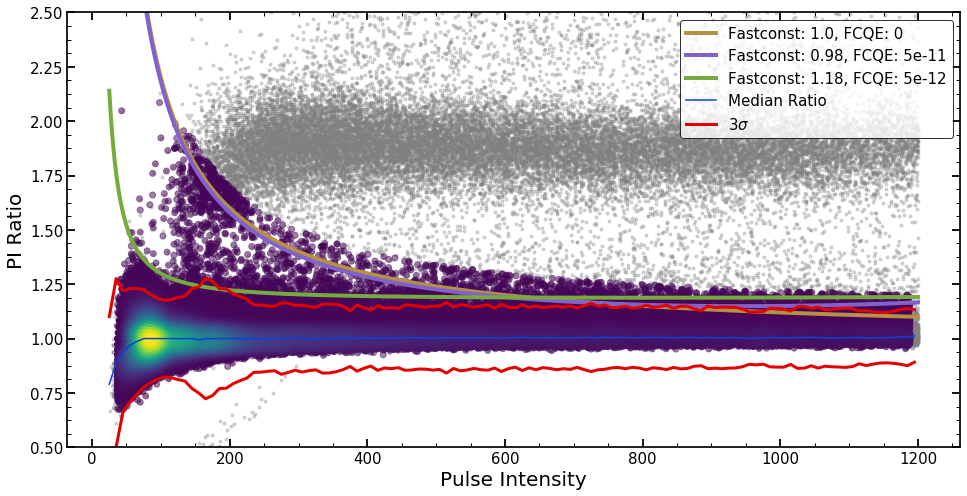

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs, label='_nolegend_' )
    return ax

ax = density_scatter(t['PI'].filled(), t['PI_RATIO'].filled(), bins=[50,50], ax=ax, alpha=.5)
ax = plotparams(ax)
ax.set_xlabel("Pulse Intensity", fontsize=20)
ax.set_ylabel("PI Ratio", fontsize=20)
ax.set_ylim(top=2.5, bottom=0.5)

xvals = np.arange(min(t['PI']), 1200, .1)

#default trumpet vals are 1.1, 1200, 0
def trumpet_function(pi, const, sig, quart, n, neg=False):
    if not neg:
        return const + (sig/10)/pi**n + quart*pi**3
    else:
        return (-1) * (const + (sig/10)/pi**n + quart*pi**3)


colors = ["#b59141",
"#8261cc",
"#75ab3d",
"#c568b4",
"#54a77a",
"#c65072",
"#688dcd",
"#cc5f3e"]



trumpet_function_params = [ [1.0, 1200, 0, 1], [.98, 1200, 5e-11, 1], 
                            [1.18, 1200, 5e-12, 1.5]]

labels = [f"Fastconst: {trumpet_function_params[i][0]}, FCQE: {trumpet_function_params[i][2]}"
          for i in range(len(trumpet_function_params)) ]

yvals = [ trumpet_function(xvals, *t) for t in trumpet_function_params ]

for i in range(len(yvals)):
    ax.plot(xvals, yvals[i], ls='-', color=colors[i], lw=4, alpha=1, label=labels[i])
    


bw = 10
pi_bins = np.arange(t['PI'].min(), t['PI'].max()+bw, bw)

grouped_ratios = [ list([]) for pi in pi_bins ]

for i in range(len(pi_bins)-1):
    lower_bin = pi_bins[i]
    upper_bin = pi_bins[i+1]
    idx = np.where( (t['PI'] >= lower_bin) & (t['PI'] < upper_bin) )[0]
    grouped_ratios[i] = t['PI_RATIO'][idx]

median_vals = [np.nanmedian(gr) for gr in grouped_ratios]
std_vals = [np.nanstd(gr) for gr in grouped_ratios]

ax.plot(pi_bins, median_vals, color='xkcd:blue', label="Median Ratio")
ax.plot(pi_bins, [ median_vals[i] + 3*std_vals[i] for i in range(len(median_vals))], 
        color='xkcd:red', label=r'$3\sigma$', lw=3)
ax.plot(pi_bins, [ median_vals[i] - 3*std_vals[i] for i in range(len(median_vals))],
        color='xkcd:red', label='_nolegend_', lw=3)

ax.legend(loc=1, edgecolor='black', fontsize=15);

ax.scatter(t_all['PI'], t_all['PI_RATIO'], color='gray', marker='.', alpha=.3, zorder=0)

In [5]:
def find_cutvals(params, t):
    cvs = np.zeros(len(t['PI']))
    for i in range(len(t['PI'])):
        if t['PI_RATIO'][i] > trumpet_function(t['PI'][i], *params):
            cvs[i] = t['PI'][i]
        else:
            cvs[i] = float('NaN')
    return cvs
            
tstart = time.time()
pool = mp.Pool(processes=mp.cpu_count()+2)
jobs = []
for params in trumpet_function_params:
    job = pool.apply_async(find_cutvals, args=(params, t,))
    jobs.append(job)

cvs_list = []
for job in jobs:
    cvs_list.append(job.get())
print(time.time() - tstart )
            

48.8552520275116


<Figure size 432x288 with 0 Axes>

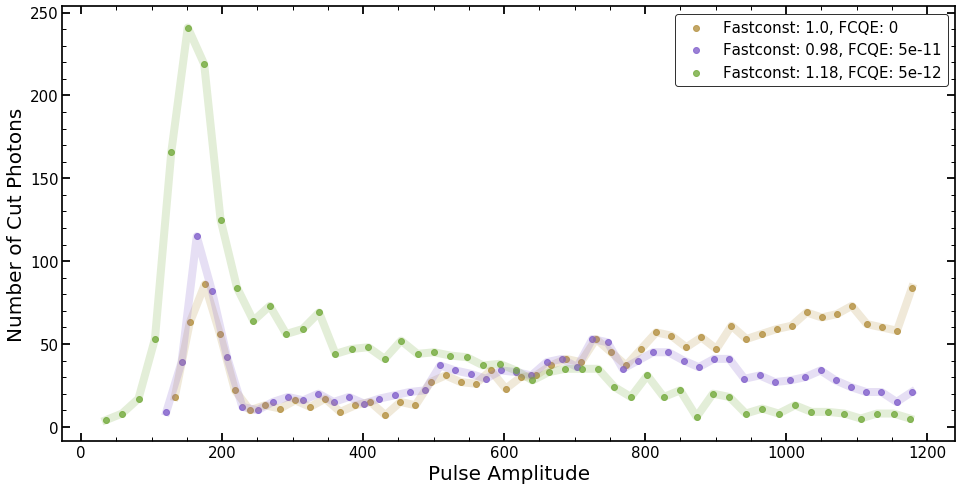

In [6]:
n_list = []
bins_list = []
nbins = 50
for i in range(len(cvs_list)):
    n, bins, patches = plt.hist(cvs_list[i][np.isfinite(cvs_list[i])], bins=nbins)
    n_list.append(n)
    bins_list.append(bins[:-1])
    
plt.clf()
    
    
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = plotparams(ax)
ax.set_xlabel("Pulse Amplitude", fontsize=20)
ax.set_ylabel("Number of Cut Photons", fontsize=20)

for i in range(len(n_list)):
    ax.scatter(bins_list[i], n_list[i], color=colors[i], alpha=.8, label=labels[i])
    ax.plot(bins_list[i], n_list[i], color=colors[i], alpha=.2, lw=8, label='_nolegend_')
    
ax.legend(loc=1, edgecolor='black', fontsize=15);
    